# Project 3: API and Reddit Classification

## Background:

Dota 2 and League of legends are 2 of the most popular Multiplayer online battle arena (MOBA) games in the world. The competition for these games have a total prize pool of over USD 40 million and USD 6 million respectively. The game is played with 2 teams consisting of 5 players each going against each other. Each player will be controlling a single game character that will be able to cast spells and attack. The objective of the game is to destroy the opponent's 'Headquarter building'. The game is very popular worldwide and requires mechanical skills and good teamwork. 

## Problem Statement:

Razor wants to market their products to the gaming community and wants to know what are the areas to target for 2 of the most popular MOBA games Dota2 and Leage of Legends. Razor only has budget to sponsor 1 of the gaming community and wants to target areas that best differentiates the 2 communities. 

To build a model that is able to differentiate reddit posts with high accuracy and provide the strongest features that differentiates the posts. To select one gaming community to promote their products and provide recommendations.

## Contents:
- [Data Cleaning / EDA](#data_cleaning)
- [Train-test-split](#train_test_split)
- [Logistic Regression](#logistic_regression)
- [Naive Bayes](#naive_bayes)
- [Random Forest](#random_forest)
- [Ada Boost](#ada_boost)
- [Support Vector Machine](#support_vector_machine)
- [Comparing models](#compare_model)
- [Conclusion and Recommendations](#conclusion_recommendations)

## Data Dictionary

| Columns   | Data type | Description                                                              |
|-----------|-----------|--------------------------------------------------------------------------|
| subreddit | object    | Subreddit the posts belong to. Dota2 and League of Legends respectively. |
| selftext  | object    | The content of the reddit post.                                          |
| title     | object    | Title of the reddit post.                                                |

## Import libraries

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

from bs4 import BeautifulSoup             

import re

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.metrics import plot_confusion_matrix, confusion_matrix

pd.set_option("display.max_rows", None)
pd.set_option("display.max_colwidth", None)

## Reading the csv file into pandas DataFrame

In [2]:
df = pd.read_csv('datasets/dota2_no_dups.csv')

In [3]:
df2 = pd.read_csv('datasets/leagueoflegends_no_dups.csv')

In [4]:
df = df[['subreddit', 'selftext', 'title']]

In [5]:
df2 = df2[['subreddit', 'selftext', 'title']]

## <a name="data_cleaning"></a>Data Cleaning

We will be replacing all Nan in the dataset with blanks and combining the 'selftext' and 'title' columns into 1 column named 'combined_text'. This is to consolidate all the words from the dataset into a single column which will be transformed into a single string later.

In [6]:
# replacing nan values with blank
df.fillna("", inplace = True)

In [7]:
df['combined_text'] = df['selftext'] + " " + df['title']

In [8]:
# we will be dropping these 2 columsn as we will not be using them
df.drop(columns = ['selftext', 'title'] , inplace=True)

In [9]:
df2.fillna("", inplace = True)

In [10]:
df2['combined_text'] = df2['selftext'] + " " + df2['title']

In [11]:
df2.drop(columns = ['selftext', 'title'] , inplace=True)

## Combined Reddit File EDA

The combined file will contain all the words which will be the data fitted into the models. We will be removing the words similar to the subreddit from the combined_text column. This is to improve our model's predicitive ability as it will not rely on words from the subreddit subject. 

In [12]:
# combining the 2 subreddits into 1 dataset
reddit = pd.concat([df, df2], ignore_index=True)

In [13]:
reddit.head()

,subreddit,combined_text
0,DotA2,"\nReady the questions! Feel free to ask anything (no matter how seemingly moronic).\n\nOther resources:\n\n- The [Dota 2 Wiki](http://www.dota2wiki.com/wiki/Dota_2_Wiki) has tons of useful information.\n\n&gt; &gt; When the first hit strikes wtih desolator, the hit stirkes as if the - armor debuff had already been placed?\n\n&gt; yes The 469th Weekly Stupid Questions Thread"
1,DotA2,Ana retires
2,DotA2,Farewell
3,DotA2,Petition to add this mic sign back
4,DotA2,arteezy choice


In [14]:
# strip the word 'dota' from combined_text
reddit['combined_text'] = reddit['combined_text'].str.replace('dota', "", case=False)

In [15]:
# strip the word 'leagueoflegends' from combined_text
reddit['combined_text'] = reddit['combined_text'].str.replace('leagueoflegends', "", case=False)

We will be building a function to clean our combined_text column. We will use row 11 as an example to test out the cleaning.

In [16]:
# to convert the text data into BeautifulSoup format to remove HTML tags
test_example = BeautifulSoup(reddit['combined_text'][11]).get_text()

In [17]:
# remove URL that starts with http\ until the next white space and replace with a single spacebar
text_example = re.sub("http\S+", " ", test_example)
text_example

"Hello /r/2, \n\nI recently used the [Open API](  to get data on >100k professional  2 games and I'm starting to do some basic analysis. One thing I decided to look at is find heroes who have one player who plays that hero more than anyone else. \n\nI wrote a script and for each hero, recorded each time any player played that hero. Then I sorted by most played and if the person who played it the most, player it at least 1.5x more times than the second highest player, I look at the top 5 players of that hero. \n\nHere are the results:\n\n|Hero|Player|Games Played|notes|\n:--|:--|--:|:--|\n|Anti-Mage|Black^|116||\n||Sylar|70||\n||Miracle-|67||\n||BurNIng|60||\n||L K -|57||\n|Brewmaster|s4|128||\n||PMA MODE 225|82|This is SmAsH|\n||DkPhobos|74||\n||9pasha|60||\n||Fata|56||\n|Chaos Knight|IllidanSTR|134|More than double second place!|\n||Era|50||\n||TheResistance|41||\n||Loda|40||\n||XBOCT|31||\n|Dawnbreaker|神秘新手|1|One one player has played this!  \n|Dragon Knight|Super！|191||\n||No[o]ne-|

In [18]:
# to remove all text that are not upper/lower alphabet characters 
letters_only = re.sub("[^a-zA-Z]", " ", test_example)

In [19]:
# change all words into lowercase and split them as a word each
words = letters_only.lower().split()

In [20]:
# remove all stopwords that are contained in the nltk stopwords 
# a set helps run the code faster
stops = set(stopwords.words('english'))
meaningful_words = [w for w in words if w not in stops]
meaningful_words

['hello',
 'r',
 'recently',
 'used',
 'open',
 'api',
 'https',
 'docs',
 'open',
 'com',
 'get',
 'data',
 'k',
 'professional',
 'games',
 'starting',
 'basic',
 'analysis',
 'one',
 'thing',
 'decided',
 'look',
 'find',
 'heroes',
 'one',
 'player',
 'plays',
 'hero',
 'anyone',
 'else',
 'wrote',
 'script',
 'hero',
 'recorded',
 'time',
 'player',
 'played',
 'hero',
 'sorted',
 'played',
 'person',
 'played',
 'player',
 'least',
 'x',
 'times',
 'second',
 'highest',
 'player',
 'look',
 'top',
 'players',
 'hero',
 'results',
 'hero',
 'player',
 'games',
 'played',
 'notes',
 'anti',
 'mage',
 'black',
 'sylar',
 'miracle',
 'burning',
 'l',
 'k',
 'brewmaster',
 'pma',
 'mode',
 'smash',
 'dkphobos',
 'pasha',
 'fata',
 'chaos',
 'knight',
 'illidanstr',
 'double',
 'second',
 'place',
 'era',
 'theresistance',
 'loda',
 'xboct',
 'dawnbreaker',
 'one',
 'one',
 'player',
 'played',
 'https',
 'dat',
 'com',
 'matches',
 'dragon',
 'knight',
 'super',
 'ne',
 'somnus',
 'al

In [21]:
def reddit_to_words(unclean_reddit):
    """Function to clean individual reddit posts in the combined_text column"""
    #1. Remove HTML tags.
    reddit_text = BeautifulSoup(unclean_reddit).get_text()
    
    #2 Remove URL that starts with http\ until the next white space
    reddit_text = re.sub("http\S+", " ", reddit_text)
    
    #3 Remove non-letters
    letters_only = re.sub("[^a-zA-Z]", " ", reddit_text)
    
    #4 Convert to lower case, split into individual words.
    words = letters_only.lower().split()
    
    #5 Convert stopwords into a set as it helps to run the code faster and remove stopwords
    # To also add in more stopwords if we find them later in the model evaluation
    stops = set(stopwords.words('english'))
    more_stopwords = ['league', 'leagues', 'legends', 'legend', 'lol']
    stops.update(more_stopwords)
    meaningful_words = [w for w in words if w not in stops]
    
    #6 Join the words back into one string seperated by space,
    # and return the result.
    return(" ".join(meaningful_words))

We will first remove all HTML tags as they will not be useful in our model. Next we will remove URL as it contains text that may confuse and worsen our model's prediction. We will then keep only letters from the post, convert it into lowercase and split each word into tokens for our model. Lastly we will remove stopwords that are not helpful or appear frequently and does not help in differentiating the posts.   

In [22]:
# WordNetLemmatizer function
def lemmatize(single_string):
    """ Function to lemmatize each word in the combined_text column """
    single_string = [WordNetLemmatizer().lemmatize(word) for word in single_string]
    return(single_string)

# PorterStemmer function
def stem(single_string):
    """ Function to PorterStemmer each word in the combined_text column """
    single_string = [PorterStemmer().stem(word) for word in single_string]
    return(single_string)

## <a name="train_test_split"></a>Train-test-split 
To cross validate and build the best model with our train data

In [23]:
# set 1 if subreddit belongs to Dota2 and 0 if it belongs to League of legends
reddit['subreddit'] = reddit['subreddit'].map(lambda x: 1 if x == 'DotA2' else 0)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    reddit[['combined_text']],
    reddit['subreddit'],
    train_size = 0.8,
    random_state = 42,
    stratify=reddit['subreddit'],
)

- Train test split the data with 80% train size, random state of 42 and stratify with y.
- We stratify with subreddit title as we want the train and test dataset to contain the same ratio of Dota2 and Leagueoflegends post in it
- To be able to compare the scores from the train and test sets

In [25]:
# baseline score of 56% (rounded up to nearest %)
y_test.value_counts(normalize=True)

1    0.559748
0    0.440252
Name: subreddit, dtype: float64

This is the baseline score that our model has to beat (56%). 

In [26]:
# cleaning both the train and test set and transforming it into a single string in a list
clean_train_reddit = []
clean_test_reddit = []

for train_post in X_train['combined_text']:
    clean_train_reddit.append(reddit_to_words(train_post))
    
for test_post in X_test['combined_text']:
    clean_test_reddit.append(reddit_to_words(test_post))

Cleaning our train and test set. Only the clean_train_reddit set will be used to train the model. The clean_test_reddit set will be used to validate the score we get from the train set and determine the bias/variance tradeoff.

## <a name="logistic_regression"></a>Logistic Regression Modelling with CountVectorizer

Logistic Regression model takes in the probability of each word occuring and classifies an outcome as 0 or 1. It will predict the probability (between 0 and 1) of a post belonging to Dota 2 or League of Legends and select the one closer to 0 or 1. 

The CountVectorizer will help transform the single string into a matrix of word counts that can be fed into the model. It will count the number of time the word appears in each reddit post and give it a positive value.

In [27]:
# instantiate CountVectorizer, fit and transform in train and transform test 
cvec = CountVectorizer()
X_train_features = cvec.fit_transform(clean_train_reddit)
X_test_features = cvec.transform(clean_test_reddit)

In [28]:
# instantiate LogisticRegression to get the default score of the model.
lr = LogisticRegression()
lr.fit(X_train_features, y_train)
lr.score(X_train_features, y_train)

0.9921197793538219

In [29]:
lr.score(X_test_features, y_test)

0.8144654088050315

The score for the train is much better than the test score. This shows that there is overfitting in the train dataset and we should try and increase bias and reduce variance by tuning the model hyperparameters.  

In [30]:
features_coef = pd.DataFrame(lr.coef_, columns = cvec.get_feature_names()).T
features_coef.sort_values(by = 0, ascending = False)

,0
animajor,1.829563e+00
ti,1.462941e+00
major,1.243164e+00
eg,1.200516e+00
weplay,1.129901e+00
iceiceice,1.021273e+00
heroes,1.008421e+00
hero,9.895185e-01
valve,9.751349e-01
mmr,9.655450e-01


The strongest features for each subreddit makes sense with features for Dota2 such as Animajor (Most recent competition), The International (The biggest prize pool competition) and EG (Evil Geniuses) - a popular Dota2 professional team.

While League of legends strongest features are ult (Ultimate) - the most powerful spell of the game character and ADC [(Attack Damage Carry)](https://leagueoflegends.fandom.com/wiki/ADC#:~:text=ADC%20(Attack%20Damage%20Carry)%20is,strike%20chance%20and%20attack%20speed.&text=ranged%20basic%20attackers%20(including%20those%20that%20do%20not%20build%20AD%2C%20e.g.&text=Fighter%20roles.) is a term that refers to a game character that deals strong, continuous damage with their basic attacks.

There are no additional stopwords to be removed as the top 10 features for each subreddit are relatable and differentiable. 

### Trying out the lemmatize and stem function

In [31]:
# try out lemmatize function with the train set
cvec_lemma = CountVectorizer(analyzer = lemmatize)
X_train_lemma_features = cvec_lemma.fit_transform(clean_train_reddit)
X_test_lemma_features = cvec_lemma.transform(clean_test_reddit)

In [32]:
# instantiate LogisticRegression to get the score with lemmatize function.
lr_lemma = LogisticRegression(max_iter=10000)
lr_lemma.fit(X_train_lemma_features, y_train)
lr_lemma.score(X_train_lemma_features, y_train)

0.6753349093774625

In [33]:
# score of the test set
lr_lemma.score(X_test_lemma_features, y_test)

0.6289308176100629

In [34]:
# try out stem function with the train set
cvec_stem = CountVectorizer(analyzer = stem)
X_train_stem_features = cvec_stem.fit_transform(clean_train_reddit)
X_test_stem_features = cvec_stem.transform(clean_test_reddit)

In [35]:
# instantiate LogisticRegression to get the score with stem function.
lr_stem = LogisticRegression(max_iter=10000)
lr_stem.fit(X_train_stem_features, y_train)
lr_stem.score(X_train_stem_features, y_train)

0.6753349093774625

In [36]:
# score of the test set
lr_stem.score(X_test_stem_features, y_test)

0.6289308176100629

The lemmatize and porterstemmer function shortens certain word to reduce the number of common features in our dataset.   

We will not be using either the lemmatize or porterstemmer function as it gives us a worse score than the score without using the function. It also distorts the word and may make some words difficult to interpret. 

### Creating a pipeline for our LogisticRegression model and running a gridsearch to find the optimal hyperparameters that gives the best accuracy for the cross validated score.

In [37]:
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression()),
])

In [38]:
pipe.get_params()

{'memory': None,
 'steps': [('cvec', CountVectorizer()), ('lr', LogisticRegression())],
 'verbose': False,
 'cvec': CountVectorizer(),
 'lr': LogisticRegression(),
 'cvec__analyzer': 'word',
 'cvec__binary': False,
 'cvec__decode_error': 'strict',
 'cvec__dtype': numpy.int64,
 'cvec__encoding': 'utf-8',
 'cvec__input': 'content',
 'cvec__lowercase': True,
 'cvec__max_df': 1.0,
 'cvec__max_features': None,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 1),
 'cvec__preprocessor': None,
 'cvec__stop_words': None,
 'cvec__strip_accents': None,
 'cvec__token_pattern': '(?u)\\b\\w\\w+\\b',
 'cvec__tokenizer': None,
 'cvec__vocabulary': None,
 'lr__C': 1.0,
 'lr__class_weight': None,
 'lr__dual': False,
 'lr__fit_intercept': True,
 'lr__intercept_scaling': 1,
 'lr__l1_ratio': None,
 'lr__max_iter': 100,
 'lr__multi_class': 'auto',
 'lr__n_jobs': None,
 'lr__penalty': 'l2',
 'lr__random_state': None,
 'lr__solver': 'lbfgs',
 'lr__tol': 0.0001,
 'lr__verbose': 0,
 'lr__warm_start': False}

In [39]:
# creating a range of parameters to run in the GridSearcch 
pipe_params = {
    'cvec__max_features': [2000, 3000, 4000],
    'cvec__min_df': [1, 2, 3],
    'cvec__max_df': [0.05, 0.1, 0.15],
    'cvec__ngram_range': [(1, 1), (1, 2)],
    'lr__penalty': ['l2', 'none']
}

In [40]:
gs = GridSearchCV(
    pipe,
    param_grid = pipe_params,
    cv = 5,
)

In [41]:
gs.fit(clean_train_reddit, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('lr', LogisticRegression())]),
             param_grid={'cvec__max_df': [0.05, 0.1, 0.15],
                         'cvec__max_features': [2000, 3000, 4000],
                         'cvec__min_df': [1, 2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2)],
                         'lr__penalty': ['l2', 'none']})

In [42]:
gs.best_params_

{'cvec__max_df': 0.1,
 'cvec__max_features': 3000,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 1),
 'lr__penalty': 'none'}

The best parameters are reducing max features to 3000, maximum % the feature can appear in each post is below 10% and minimum time the feature can appear is 1 which is the default. This will help combat overfitting and improve our cross validated score. 

In [43]:
gs.best_score_

0.8242320500451278

In [44]:
gs_model = gs.best_estimator_

In [45]:
gs_model.score(clean_train_reddit, y_train)

0.9992119779353822

In [46]:
gs_model.score(clean_test_reddit, y_test)

0.839622641509434

The cross validated score is better after grid searching through for the optimal hyperparameters. We reduced overfitting and lowered the variance. This will help our model predict better with new data.  

## Logistic Regression Modelling with TF-IDF Vectorizer

TF-IDF Vectorizer will help transform the single string into a matrix of word counts which is then weighted with the total number of words. This will help scale down the impact of words that occur very frequently which are less informative than words that occur in a small fraction. This will help improve our model prediction as it regularizes the features.

In [47]:
pipe_tvec = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('lr', LogisticRegression())
])

In [48]:
pipe_tvec.get_params()

{'memory': None,
 'steps': [('tvec', TfidfVectorizer()), ('lr', LogisticRegression())],
 'verbose': False,
 'tvec': TfidfVectorizer(),
 'lr': LogisticRegression(),
 'tvec__analyzer': 'word',
 'tvec__binary': False,
 'tvec__decode_error': 'strict',
 'tvec__dtype': numpy.float64,
 'tvec__encoding': 'utf-8',
 'tvec__input': 'content',
 'tvec__lowercase': True,
 'tvec__max_df': 1.0,
 'tvec__max_features': None,
 'tvec__min_df': 1,
 'tvec__ngram_range': (1, 1),
 'tvec__norm': 'l2',
 'tvec__preprocessor': None,
 'tvec__smooth_idf': True,
 'tvec__stop_words': None,
 'tvec__strip_accents': None,
 'tvec__sublinear_tf': False,
 'tvec__token_pattern': '(?u)\\b\\w\\w+\\b',
 'tvec__tokenizer': None,
 'tvec__use_idf': True,
 'tvec__vocabulary': None,
 'lr__C': 1.0,
 'lr__class_weight': None,
 'lr__dual': False,
 'lr__fit_intercept': True,
 'lr__intercept_scaling': 1,
 'lr__l1_ratio': None,
 'lr__max_iter': 100,
 'lr__multi_class': 'auto',
 'lr__n_jobs': None,
 'lr__penalty': 'l2',
 'lr__random_state

In [49]:
pipe_params_tvec = {
    'tvec__max_features': [1500, 2000, 3000, 4000],
    'tvec__min_df': [1, 2, 3],
    'tvec__max_df': [0.05, 0.1, 0.2],
    'tvec__ngram_range': [(1, 1), (1, 2)],
    'lr__penalty': ['l2', 'none']
}

In [50]:
gs_tvec = GridSearchCV(
    pipe_tvec,
    param_grid = pipe_params_tvec,
    cv=5
)

In [51]:
gs_tvec.fit(clean_train_reddit, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('lr', LogisticRegression())]),
             param_grid={'lr__penalty': ['l2', 'none'],
                         'tvec__max_df': [0.05, 0.1, 0.2],
                         'tvec__max_features': [1500, 2000, 3000, 4000],
                         'tvec__min_df': [1, 2, 3],
                         'tvec__ngram_range': [(1, 1), (1, 2)]})

In [52]:
gs_tvec.best_estimator_

Pipeline(steps=[('tvec', TfidfVectorizer(max_df=0.1, max_features=3000)),
                ('lr', LogisticRegression())])

In [53]:
gs_tvec.best_params_

{'lr__penalty': 'l2',
 'tvec__max_df': 0.1,
 'tvec__max_features': 3000,
 'tvec__min_df': 1,
 'tvec__ngram_range': (1, 1)}

In [54]:
gs_tvec.best_score_

0.8439575487846629

In [55]:
gs_tvec_model = gs_tvec.best_estimator_

In [56]:
gs_tvec_model.score(clean_train_reddit, y_train)

0.9676910953506698

In [57]:
gs_tvec_model.score(clean_test_reddit, y_test)

0.8553459119496856

The cross validated score is better than the score we did with CountVectorizer. This is because TF-IDF vectorizer regularizes the coefficients by 'punishing' words that occur frequently and reduces variance.
We will next try a few more different classifier models with Count/TF-IDF Vectorizer. 

## <a name="naive_bayes"></a>Multinomial Naive Bayes Modelling with CountVectorizer

Multinomial Naive Bayes model takes in the frequency of each word occuring and classifies an outcome as 0 or 1. It will predict the probability (between 0 and 1) of a post belonging to Dota 2 or League of Legends and select the one closer to 0 or 1.

In [58]:
pipe_nb = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

In [59]:
pipe_nb.get_params()

{'memory': None,
 'steps': [('cvec', CountVectorizer()), ('nb', MultinomialNB())],
 'verbose': False,
 'cvec': CountVectorizer(),
 'nb': MultinomialNB(),
 'cvec__analyzer': 'word',
 'cvec__binary': False,
 'cvec__decode_error': 'strict',
 'cvec__dtype': numpy.int64,
 'cvec__encoding': 'utf-8',
 'cvec__input': 'content',
 'cvec__lowercase': True,
 'cvec__max_df': 1.0,
 'cvec__max_features': None,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 1),
 'cvec__preprocessor': None,
 'cvec__stop_words': None,
 'cvec__strip_accents': None,
 'cvec__token_pattern': '(?u)\\b\\w\\w+\\b',
 'cvec__tokenizer': None,
 'cvec__vocabulary': None,
 'nb__alpha': 1.0,
 'nb__class_prior': None,
 'nb__fit_prior': True}

In [60]:
pipe_nb_params = {
    'cvec__max_features': [3000, 4000, 5000],
    'cvec__min_df': [1, 2, 3],
    'cvec__max_df': [0.05, 0.1, 0.15],
    'cvec__ngram_range': [(1, 1), (1, 2)],
    'nb__alpha': [0.4, 0.5, 0.6],
}

In [61]:
gs_nb = GridSearchCV(
    pipe_nb,
    param_grid = pipe_nb_params,
    cv=5,
)

In [62]:
gs_nb.fit(clean_train_reddit, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'cvec__max_df': [0.05, 0.1, 0.15],
                         'cvec__max_features': [3000, 4000, 5000],
                         'cvec__min_df': [1, 2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2)],
                         'nb__alpha': [0.4, 0.5, 0.6]})

In [63]:
gs_nb.best_estimator_

Pipeline(steps=[('cvec', CountVectorizer(max_df=0.1, max_features=4000)),
                ('nb', MultinomialNB(alpha=0.5))])

In [64]:
gs_nb.best_params_

{'cvec__max_df': 0.1,
 'cvec__max_features': 4000,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 1),
 'nb__alpha': 0.5}

In [65]:
gs_nb.best_score_

0.8400018673555133

In [66]:
gs_nb_model = gs_nb.best_estimator_

In [67]:
gs_nb_model.score(clean_train_reddit, y_train)

0.9369582348305753

In [68]:
gs_nb_model.score(clean_test_reddit, y_test)

0.8742138364779874

The cross validated score is not as good as the Logistic Regression. However the test score is much better as we reduced overfitting and variance with count vectorizer limit of 4000 features and only features that appear in less than 10% of the posts.

## Naive Bayes Modelling with TF-IDF Vectorizer

In [69]:
pipe_nb_tvec = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

In [70]:
pipe_nb_tvec.get_params()

{'memory': None,
 'steps': [('tvec', TfidfVectorizer()), ('nb', MultinomialNB())],
 'verbose': False,
 'tvec': TfidfVectorizer(),
 'nb': MultinomialNB(),
 'tvec__analyzer': 'word',
 'tvec__binary': False,
 'tvec__decode_error': 'strict',
 'tvec__dtype': numpy.float64,
 'tvec__encoding': 'utf-8',
 'tvec__input': 'content',
 'tvec__lowercase': True,
 'tvec__max_df': 1.0,
 'tvec__max_features': None,
 'tvec__min_df': 1,
 'tvec__ngram_range': (1, 1),
 'tvec__norm': 'l2',
 'tvec__preprocessor': None,
 'tvec__smooth_idf': True,
 'tvec__stop_words': None,
 'tvec__strip_accents': None,
 'tvec__sublinear_tf': False,
 'tvec__token_pattern': '(?u)\\b\\w\\w+\\b',
 'tvec__tokenizer': None,
 'tvec__use_idf': True,
 'tvec__vocabulary': None,
 'nb__alpha': 1.0,
 'nb__class_prior': None,
 'nb__fit_prior': True}

In [71]:
pipe_nb_tvec_params = {
    'tvec__max_features': [4000, 5000, 6000],
    'tvec__min_df': [1, 2, 3],
    'tvec__max_df': [0.2, 0.25, 0.3],
    'tvec__ngram_range': [(1, 1), (1, 2)],
    'nb__alpha': [0.2, 0.25, 0.3],
}

In [72]:
gs_nb_tvec = GridSearchCV(
    pipe_nb_tvec,
    param_grid = pipe_nb_tvec_params,
    cv=5,
)

In [73]:
gs_nb_tvec.fit(clean_train_reddit, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'nb__alpha': [0.2, 0.25, 0.3],
                         'tvec__max_df': [0.2, 0.25, 0.3],
                         'tvec__max_features': [4000, 5000, 6000],
                         'tvec__min_df': [1, 2, 3],
                         'tvec__ngram_range': [(1, 1), (1, 2)]})

In [74]:
gs_nb_tvec.best_estimator_

Pipeline(steps=[('tvec',
                 TfidfVectorizer(max_df=0.25, max_features=5000,
                                 ngram_range=(1, 2))),
                ('nb', MultinomialNB(alpha=0.25))])

In [75]:
gs_nb_tvec.best_params_

{'nb__alpha': 0.25,
 'tvec__max_df': 0.25,
 'tvec__max_features': 5000,
 'tvec__min_df': 1,
 'tvec__ngram_range': (1, 2)}

In [76]:
gs_nb_tvec.best_score_

0.8644237652111668

In [77]:
gs_nb_tvec_model = gs_nb_tvec.best_estimator_

In [78]:
gs_nb_tvec_model.score(clean_train_reddit, y_train)

0.9818754925137904

In [79]:
gs_nb_tvec_model.score(clean_test_reddit, y_test)

0.8679245283018868

The cross validated score so far gives the highest accuracy. We reduced overfitting with TF-IDF vectorizer limiting features to 5000 and only features that appear in less than 25% of the posts. 

## <a name="random_forest"></a>Random Forest modelling with CountVectorizer

Random Forest model will create n numbers of decision tree classifiers that takes in a random subset of sample and features from the dataset. Then it will take the aggregate score of all the decision trees and predicts an outcome of 0 or 1. 

In [80]:
pipe_rf = Pipeline([
    ('cvec', CountVectorizer()),
    ('rf', RandomForestClassifier(n_estimators=100, n_jobs=-1))
])

In [81]:
pipe_rf.get_params()

{'memory': None,
 'steps': [('cvec', CountVectorizer()),
  ('rf', RandomForestClassifier(n_jobs=-1))],
 'verbose': False,
 'cvec': CountVectorizer(),
 'rf': RandomForestClassifier(n_jobs=-1),
 'cvec__analyzer': 'word',
 'cvec__binary': False,
 'cvec__decode_error': 'strict',
 'cvec__dtype': numpy.int64,
 'cvec__encoding': 'utf-8',
 'cvec__input': 'content',
 'cvec__lowercase': True,
 'cvec__max_df': 1.0,
 'cvec__max_features': None,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 1),
 'cvec__preprocessor': None,
 'cvec__stop_words': None,
 'cvec__strip_accents': None,
 'cvec__token_pattern': '(?u)\\b\\w\\w+\\b',
 'cvec__tokenizer': None,
 'cvec__vocabulary': None,
 'rf__bootstrap': True,
 'rf__ccp_alpha': 0.0,
 'rf__class_weight': None,
 'rf__criterion': 'gini',
 'rf__max_depth': None,
 'rf__max_features': 'auto',
 'rf__max_leaf_nodes': None,
 'rf__max_samples': None,
 'rf__min_impurity_decrease': 0.0,
 'rf__min_impurity_split': None,
 'rf__min_samples_leaf': 1,
 'rf__min_samples_split':

In [82]:
pipe_rf_params = {
    'cvec__max_features': [4000, 5000, 6000],
    'cvec__min_df': [1, 2, 3],
    'cvec__max_df': [0.15, 0.3, 0.5],
#     'cvec__ngram_range': [(1, 1), (1, 2)],
#     'rf__n_estimators': [100],
#     'rf__max_depth': [None, 2, 4],
    'rf__max_features': ['sqrt', 'auto']
}

In [83]:
gs_rf = GridSearchCV(
    pipe_rf,
    param_grid = pipe_rf_params,
    cv=5,
    verbose=2,
)

In [84]:
gs_rf.fit(clean_train_reddit, y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV] END cvec__max_df=0.15, cvec__max_features=4000, cvec__min_df=1, rf__max_features=sqrt; total time=   2.9s
[CV] END cvec__max_df=0.15, cvec__max_features=4000, cvec__min_df=1, rf__max_features=sqrt; total time=   0.1s
[CV] END cvec__max_df=0.15, cvec__max_features=4000, cvec__min_df=1, rf__max_features=sqrt; total time=   0.1s
[CV] END cvec__max_df=0.15, cvec__max_features=4000, cvec__min_df=1, rf__max_features=sqrt; total time=   0.1s
[CV] END cvec__max_df=0.15, cvec__max_features=4000, cvec__min_df=1, rf__max_features=sqrt; total time=   0.1s
[CV] END cvec__max_df=0.15, cvec__max_features=4000, cvec__min_df=1, rf__max_features=auto; total time=   0.1s
[CV] END cvec__max_df=0.15, cvec__max_features=4000, cvec__min_df=1, rf__max_features=auto; total time=   0.1s
[CV] END cvec__max_df=0.15, cvec__max_features=4000, cvec__min_df=1, rf__max_features=auto; total time=   0.1s
[CV] END cvec__max_df=0.15, cvec__max_features=400

[CV] END cvec__max_df=0.15, cvec__max_features=6000, cvec__min_df=2, rf__max_features=sqrt; total time=   0.1s
[CV] END cvec__max_df=0.15, cvec__max_features=6000, cvec__min_df=2, rf__max_features=auto; total time=   0.1s
[CV] END cvec__max_df=0.15, cvec__max_features=6000, cvec__min_df=2, rf__max_features=auto; total time=   0.1s
[CV] END cvec__max_df=0.15, cvec__max_features=6000, cvec__min_df=2, rf__max_features=auto; total time=   0.1s
[CV] END cvec__max_df=0.15, cvec__max_features=6000, cvec__min_df=2, rf__max_features=auto; total time=   0.1s
[CV] END cvec__max_df=0.15, cvec__max_features=6000, cvec__min_df=2, rf__max_features=auto; total time=   0.1s
[CV] END cvec__max_df=0.15, cvec__max_features=6000, cvec__min_df=3, rf__max_features=sqrt; total time=   0.1s
[CV] END cvec__max_df=0.15, cvec__max_features=6000, cvec__min_df=3, rf__max_features=sqrt; total time=   0.1s
[CV] END cvec__max_df=0.15, cvec__max_features=6000, cvec__min_df=3, rf__max_features=sqrt; total time=   0.1s
[

[CV] END cvec__max_df=0.3, cvec__max_features=6000, cvec__min_df=1, rf__max_features=sqrt; total time=   0.2s
[CV] END cvec__max_df=0.3, cvec__max_features=6000, cvec__min_df=1, rf__max_features=sqrt; total time=   0.1s
[CV] END cvec__max_df=0.3, cvec__max_features=6000, cvec__min_df=1, rf__max_features=sqrt; total time=   0.1s
[CV] END cvec__max_df=0.3, cvec__max_features=6000, cvec__min_df=1, rf__max_features=sqrt; total time=   0.1s
[CV] END cvec__max_df=0.3, cvec__max_features=6000, cvec__min_df=1, rf__max_features=sqrt; total time=   0.1s
[CV] END cvec__max_df=0.3, cvec__max_features=6000, cvec__min_df=1, rf__max_features=auto; total time=   0.1s
[CV] END cvec__max_df=0.3, cvec__max_features=6000, cvec__min_df=1, rf__max_features=auto; total time=   0.1s
[CV] END cvec__max_df=0.3, cvec__max_features=6000, cvec__min_df=1, rf__max_features=auto; total time=   0.1s
[CV] END cvec__max_df=0.3, cvec__max_features=6000, cvec__min_df=1, rf__max_features=auto; total time=   0.1s
[CV] END c

[CV] END cvec__max_df=0.5, cvec__max_features=5000, cvec__min_df=2, rf__max_features=auto; total time=   0.1s
[CV] END cvec__max_df=0.5, cvec__max_features=5000, cvec__min_df=2, rf__max_features=auto; total time=   0.1s
[CV] END cvec__max_df=0.5, cvec__max_features=5000, cvec__min_df=2, rf__max_features=auto; total time=   0.1s
[CV] END cvec__max_df=0.5, cvec__max_features=5000, cvec__min_df=2, rf__max_features=auto; total time=   0.1s
[CV] END cvec__max_df=0.5, cvec__max_features=5000, cvec__min_df=3, rf__max_features=sqrt; total time=   0.1s
[CV] END cvec__max_df=0.5, cvec__max_features=5000, cvec__min_df=3, rf__max_features=sqrt; total time=   0.1s
[CV] END cvec__max_df=0.5, cvec__max_features=5000, cvec__min_df=3, rf__max_features=sqrt; total time=   0.1s
[CV] END cvec__max_df=0.5, cvec__max_features=5000, cvec__min_df=3, rf__max_features=sqrt; total time=   0.1s
[CV] END cvec__max_df=0.5, cvec__max_features=5000, cvec__min_df=3, rf__max_features=sqrt; total time=   0.1s
[CV] END c

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('rf',
                                        RandomForestClassifier(n_jobs=-1))]),
             param_grid={'cvec__max_df': [0.15, 0.3, 0.5],
                         'cvec__max_features': [4000, 5000, 6000],
                         'cvec__min_df': [1, 2, 3],
                         'rf__max_features': ['sqrt', 'auto']},
             verbose=2)

In [85]:
gs_rf.best_params_

{'cvec__max_df': 0.15,
 'cvec__max_features': 5000,
 'cvec__min_df': 1,
 'rf__max_features': 'auto'}

In [86]:
gs_rf.best_score_

0.817157884908655

In [87]:
gs_rf_model = gs_rf.best_estimator_

In [88]:
gs_rf_model.score(clean_train_reddit, y_train)

0.9992119779353822

In [89]:
gs_rf_model.score(clean_test_reddit, y_test)

0.7955974842767296

The cross validated score is not as good as the previous models. This model might not be suitable for this dataset as it takes a random subset of samples and features from the whole dataset. The number of features available is 5000 while the total number of samples is only around 1000.

## Random Forest modelling with TF-IDF Vectorizer

In [90]:
pipe_rf_tvec = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('rf', RandomForestClassifier(n_estimators=100, n_jobs=-1))
])

In [91]:
pipe_rf_tvec.get_params()

{'memory': None,
 'steps': [('tvec', TfidfVectorizer()),
  ('rf', RandomForestClassifier(n_jobs=-1))],
 'verbose': False,
 'tvec': TfidfVectorizer(),
 'rf': RandomForestClassifier(n_jobs=-1),
 'tvec__analyzer': 'word',
 'tvec__binary': False,
 'tvec__decode_error': 'strict',
 'tvec__dtype': numpy.float64,
 'tvec__encoding': 'utf-8',
 'tvec__input': 'content',
 'tvec__lowercase': True,
 'tvec__max_df': 1.0,
 'tvec__max_features': None,
 'tvec__min_df': 1,
 'tvec__ngram_range': (1, 1),
 'tvec__norm': 'l2',
 'tvec__preprocessor': None,
 'tvec__smooth_idf': True,
 'tvec__stop_words': None,
 'tvec__strip_accents': None,
 'tvec__sublinear_tf': False,
 'tvec__token_pattern': '(?u)\\b\\w\\w+\\b',
 'tvec__tokenizer': None,
 'tvec__use_idf': True,
 'tvec__vocabulary': None,
 'rf__bootstrap': True,
 'rf__ccp_alpha': 0.0,
 'rf__class_weight': None,
 'rf__criterion': 'gini',
 'rf__max_depth': None,
 'rf__max_features': 'auto',
 'rf__max_leaf_nodes': None,
 'rf__max_samples': None,
 'rf__min_impurit

In [92]:
pipe_rf_tvec_params = {
    'tvec__max_features': [500, 1000, 2000, 3000],
    'tvec__min_df': [2, 3, 4],
    'tvec__max_df': [0.1, 0.15, 0.3],
#     'tvec__ngram_range': [(1, 1), (1, 2)],
#     'rf__n_estimators': [100],
#     'rf__max_depth': [None, 2, 4],
    'rf__max_features': ['sqrt', 'auto']
}

In [93]:
gs_rf_tvec = GridSearchCV(
    pipe_rf_tvec,
    param_grid = pipe_rf_tvec_params,
    cv=5,
    verbose=2,
)

In [94]:
gs_rf_tvec.fit(clean_train_reddit, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV] END rf__max_features=sqrt, tvec__max_df=0.1, tvec__max_features=500, tvec__min_df=2; total time=   0.1s
[CV] END rf__max_features=sqrt, tvec__max_df=0.1, tvec__max_features=500, tvec__min_df=2; total time=   0.1s
[CV] END rf__max_features=sqrt, tvec__max_df=0.1, tvec__max_features=500, tvec__min_df=2; total time=   0.1s
[CV] END rf__max_features=sqrt, tvec__max_df=0.1, tvec__max_features=500, tvec__min_df=2; total time=   0.1s
[CV] END rf__max_features=sqrt, tvec__max_df=0.1, tvec__max_features=500, tvec__min_df=2; total time=   0.1s
[CV] END rf__max_features=sqrt, tvec__max_df=0.1, tvec__max_features=500, tvec__min_df=3; total time=   0.1s
[CV] END rf__max_features=sqrt, tvec__max_df=0.1, tvec__max_features=500, tvec__min_df=3; total time=   0.1s
[CV] END rf__max_features=sqrt, tvec__max_df=0.1, tvec__max_features=500, tvec__min_df=3; total time=   0.1s
[CV] END rf__max_features=sqrt, tvec__max_df=0.1, tvec__max_featur

[CV] END rf__max_features=sqrt, tvec__max_df=0.15, tvec__max_features=1000, tvec__min_df=2; total time=   0.1s
[CV] END rf__max_features=sqrt, tvec__max_df=0.15, tvec__max_features=1000, tvec__min_df=2; total time=   0.1s
[CV] END rf__max_features=sqrt, tvec__max_df=0.15, tvec__max_features=1000, tvec__min_df=2; total time=   0.1s
[CV] END rf__max_features=sqrt, tvec__max_df=0.15, tvec__max_features=1000, tvec__min_df=2; total time=   0.1s
[CV] END rf__max_features=sqrt, tvec__max_df=0.15, tvec__max_features=1000, tvec__min_df=3; total time=   0.1s
[CV] END rf__max_features=sqrt, tvec__max_df=0.15, tvec__max_features=1000, tvec__min_df=3; total time=   0.1s
[CV] END rf__max_features=sqrt, tvec__max_df=0.15, tvec__max_features=1000, tvec__min_df=3; total time=   0.1s
[CV] END rf__max_features=sqrt, tvec__max_df=0.15, tvec__max_features=1000, tvec__min_df=3; total time=   0.1s
[CV] END rf__max_features=sqrt, tvec__max_df=0.15, tvec__max_features=1000, tvec__min_df=3; total time=   0.1s
[

[CV] END rf__max_features=sqrt, tvec__max_df=0.3, tvec__max_features=2000, tvec__min_df=2; total time=   0.1s
[CV] END rf__max_features=sqrt, tvec__max_df=0.3, tvec__max_features=2000, tvec__min_df=2; total time=   0.1s
[CV] END rf__max_features=sqrt, tvec__max_df=0.3, tvec__max_features=2000, tvec__min_df=2; total time=   0.1s
[CV] END rf__max_features=sqrt, tvec__max_df=0.3, tvec__max_features=2000, tvec__min_df=2; total time=   0.1s
[CV] END rf__max_features=sqrt, tvec__max_df=0.3, tvec__max_features=2000, tvec__min_df=3; total time=   0.1s
[CV] END rf__max_features=sqrt, tvec__max_df=0.3, tvec__max_features=2000, tvec__min_df=3; total time=   0.1s
[CV] END rf__max_features=sqrt, tvec__max_df=0.3, tvec__max_features=2000, tvec__min_df=3; total time=   0.1s
[CV] END rf__max_features=sqrt, tvec__max_df=0.3, tvec__max_features=2000, tvec__min_df=3; total time=   0.1s
[CV] END rf__max_features=sqrt, tvec__max_df=0.3, tvec__max_features=2000, tvec__min_df=3; total time=   0.1s
[CV] END r

[CV] END rf__max_features=auto, tvec__max_df=0.1, tvec__max_features=3000, tvec__min_df=2; total time=   0.1s
[CV] END rf__max_features=auto, tvec__max_df=0.1, tvec__max_features=3000, tvec__min_df=2; total time=   0.1s
[CV] END rf__max_features=auto, tvec__max_df=0.1, tvec__max_features=3000, tvec__min_df=2; total time=   0.1s
[CV] END rf__max_features=auto, tvec__max_df=0.1, tvec__max_features=3000, tvec__min_df=2; total time=   0.1s
[CV] END rf__max_features=auto, tvec__max_df=0.1, tvec__max_features=3000, tvec__min_df=3; total time=   0.1s
[CV] END rf__max_features=auto, tvec__max_df=0.1, tvec__max_features=3000, tvec__min_df=3; total time=   0.1s
[CV] END rf__max_features=auto, tvec__max_df=0.1, tvec__max_features=3000, tvec__min_df=3; total time=   0.1s
[CV] END rf__max_features=auto, tvec__max_df=0.1, tvec__max_features=3000, tvec__min_df=3; total time=   0.1s
[CV] END rf__max_features=auto, tvec__max_df=0.1, tvec__max_features=3000, tvec__min_df=3; total time=   0.1s
[CV] END r

[CV] END rf__max_features=auto, tvec__max_df=0.3, tvec__max_features=500, tvec__min_df=2; total time=   0.1s
[CV] END rf__max_features=auto, tvec__max_df=0.3, tvec__max_features=500, tvec__min_df=2; total time=   0.1s
[CV] END rf__max_features=auto, tvec__max_df=0.3, tvec__max_features=500, tvec__min_df=2; total time=   0.1s
[CV] END rf__max_features=auto, tvec__max_df=0.3, tvec__max_features=500, tvec__min_df=3; total time=   0.1s
[CV] END rf__max_features=auto, tvec__max_df=0.3, tvec__max_features=500, tvec__min_df=3; total time=   0.1s
[CV] END rf__max_features=auto, tvec__max_df=0.3, tvec__max_features=500, tvec__min_df=3; total time=   0.1s
[CV] END rf__max_features=auto, tvec__max_df=0.3, tvec__max_features=500, tvec__min_df=3; total time=   0.1s
[CV] END rf__max_features=auto, tvec__max_df=0.3, tvec__max_features=500, tvec__min_df=3; total time=   0.1s
[CV] END rf__max_features=auto, tvec__max_df=0.3, tvec__max_features=500, tvec__min_df=4; total time=   0.1s
[CV] END rf__max_fe

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('rf',
                                        RandomForestClassifier(n_jobs=-1))]),
             param_grid={'rf__max_features': ['sqrt', 'auto'],
                         'tvec__max_df': [0.1, 0.15, 0.3],
                         'tvec__max_features': [500, 1000, 2000, 3000],
                         'tvec__min_df': [2, 3, 4]},
             verbose=2)

In [95]:
gs_rf_tvec.best_estimator_

Pipeline(steps=[('tvec',
                 TfidfVectorizer(max_df=0.15, max_features=2000, min_df=3)),
                ('rf', RandomForestClassifier(max_features='sqrt', n_jobs=-1))])

In [96]:
gs_rf_tvec.best_params_

{'rf__max_features': 'sqrt',
 'tvec__max_df': 0.15,
 'tvec__max_features': 2000,
 'tvec__min_df': 3}

In [97]:
gs_rf_tvec.best_score_

0.8084871308082537

In [98]:
gs_rf_tvec_model = gs_rf_tvec.best_estimator_

In [99]:
gs_rf_tvec_model.score(clean_train_reddit, y_train)

0.9976359338061466

In [100]:
gs_rf_tvec_model.score(clean_test_reddit, y_test)

0.8050314465408805

The cross validated score is still not as good as the previous models even with TF-IDF vectorizer that regularizes the features to combat overfitting. We will not be using this model.  

## <a name="ada_boost"></a>Ada boost modelling with CountVectorizer

Ada Boost classifier begins with a default Decision Tree classifier that takes in a uniform weight of features. It will then produce n number of models that 'learns' from the previous model by adjusting the weight of the incorrectly classified feature. At the end, all the decision trees are given a weight depending on the misclassification rate. The total score will then predict an outcome of 0 or 1. 

In [101]:
pipe_ada = Pipeline([
    ('cvec', CountVectorizer()),
    ('ada', AdaBoostClassifier(n_estimators=150))
])

In [102]:
pipe_ada.get_params()

{'memory': None,
 'steps': [('cvec', CountVectorizer()),
  ('ada', AdaBoostClassifier(n_estimators=150))],
 'verbose': False,
 'cvec': CountVectorizer(),
 'ada': AdaBoostClassifier(n_estimators=150),
 'cvec__analyzer': 'word',
 'cvec__binary': False,
 'cvec__decode_error': 'strict',
 'cvec__dtype': numpy.int64,
 'cvec__encoding': 'utf-8',
 'cvec__input': 'content',
 'cvec__lowercase': True,
 'cvec__max_df': 1.0,
 'cvec__max_features': None,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 1),
 'cvec__preprocessor': None,
 'cvec__stop_words': None,
 'cvec__strip_accents': None,
 'cvec__token_pattern': '(?u)\\b\\w\\w+\\b',
 'cvec__tokenizer': None,
 'cvec__vocabulary': None,
 'ada__algorithm': 'SAMME.R',
 'ada__base_estimator': None,
 'ada__learning_rate': 1.0,
 'ada__n_estimators': 150,
 'ada__random_state': None}

In [103]:
pipe_ada_params = {
    'cvec__max_features': [2000, 3000, 4000],
    'cvec__min_df': [2, 3, 4],
    'cvec__max_df': [0.2, 0.3, 0.5],
    'ada__learning_rate': [0.01, 0.1, 1]
}

In [104]:
gs_ada = GridSearchCV(
    pipe_ada,
    param_grid = pipe_ada_params,
    cv=5,
    verbose=1
)

In [105]:
gs_ada.fit(clean_train_reddit, y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('ada',
                                        AdaBoostClassifier(n_estimators=150))]),
             param_grid={'ada__learning_rate': [0.01, 0.1, 1],
                         'cvec__max_df': [0.2, 0.3, 0.5],
                         'cvec__max_features': [2000, 3000, 4000],
                         'cvec__min_df': [2, 3, 4]},
             verbose=1)

In [106]:
gs_ada.best_params_

{'ada__learning_rate': 1,
 'cvec__max_df': 0.3,
 'cvec__max_features': 3000,
 'cvec__min_df': 3}

In [107]:
gs_ada.best_score_

0.8321496374218045

In [108]:
gs_ada_model = gs_ada.best_estimator_

In [109]:
gs_ada_model.score(clean_train_reddit, y_train)

0.9637509850275807

In [110]:
gs_ada_model.score(clean_test_reddit, y_test)

0.8270440251572327

The model runs 150 models and each new model 'learns' from the previous model and weights the wrong features accordingly. The cross validated score is not the best and we will not be using this model.  

## Ada boost modelling with TF-IDF Vectorizer

In [111]:
pipe_ada_tvec = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('ada', AdaBoostClassifier(n_estimators=150))
])

In [112]:
pipe_ada_tvec.get_params()

{'memory': None,
 'steps': [('tvec', TfidfVectorizer()),
  ('ada', AdaBoostClassifier(n_estimators=150))],
 'verbose': False,
 'tvec': TfidfVectorizer(),
 'ada': AdaBoostClassifier(n_estimators=150),
 'tvec__analyzer': 'word',
 'tvec__binary': False,
 'tvec__decode_error': 'strict',
 'tvec__dtype': numpy.float64,
 'tvec__encoding': 'utf-8',
 'tvec__input': 'content',
 'tvec__lowercase': True,
 'tvec__max_df': 1.0,
 'tvec__max_features': None,
 'tvec__min_df': 1,
 'tvec__ngram_range': (1, 1),
 'tvec__norm': 'l2',
 'tvec__preprocessor': None,
 'tvec__smooth_idf': True,
 'tvec__stop_words': None,
 'tvec__strip_accents': None,
 'tvec__sublinear_tf': False,
 'tvec__token_pattern': '(?u)\\b\\w\\w+\\b',
 'tvec__tokenizer': None,
 'tvec__use_idf': True,
 'tvec__vocabulary': None,
 'ada__algorithm': 'SAMME.R',
 'ada__base_estimator': None,
 'ada__learning_rate': 1.0,
 'ada__n_estimators': 150,
 'ada__random_state': None}

In [113]:
pipe_ada_tvec_params = {
    'tvec__max_features': [3000, 4000, 5000],
    'tvec__min_df': [1, 2, 3],
    'tvec__max_df': [0.2, 0.3, 0.5],
}

In [114]:
gs_ada_tvec = GridSearchCV(
    pipe_ada_tvec,
    param_grid = pipe_ada_tvec_params,
    cv=5,
    verbose=1
)

In [115]:
gs_ada_tvec.fit(clean_train_reddit, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('ada',
                                        AdaBoostClassifier(n_estimators=150))]),
             param_grid={'tvec__max_df': [0.2, 0.3, 0.5],
                         'tvec__max_features': [3000, 4000, 5000],
                         'tvec__min_df': [1, 2, 3]},
             verbose=1)

In [116]:
gs_ada_tvec.best_params_

{'tvec__max_df': 0.3, 'tvec__max_features': 4000, 'tvec__min_df': 2}

In [117]:
gs_ada_tvec.best_score_

0.8045687964893716

In [118]:
gs_ada_tvec_model = gs_ada_tvec.best_estimator_

In [119]:
gs_ada_tvec_model.score(clean_train_reddit, y_train)

0.9747832939322301

In [120]:
gs_ada_tvec_model.score(clean_test_reddit, y_test)

0.8238993710691824

We will be able to improve the score if we increase the n_estimators of models to learn. However as the cross validated score is not the best, we will not waste time trying to finetune it as we will not be using this model. 

## <a name="support_vector_machine"></a>Support vector machine modelling with CountVectorizer

Support vector machine is a classifier that finds the best line (hyperplane) separating the features into the correct group (0 or 1) and maximizes the distance between the line and features. 

In [121]:
pipe_svc = Pipeline([
    ('cvec', CountVectorizer()),
    ('svc', SVC())
])

In [122]:
pipe_svc.get_params()

{'memory': None,
 'steps': [('cvec', CountVectorizer()), ('svc', SVC())],
 'verbose': False,
 'cvec': CountVectorizer(),
 'svc': SVC(),
 'cvec__analyzer': 'word',
 'cvec__binary': False,
 'cvec__decode_error': 'strict',
 'cvec__dtype': numpy.int64,
 'cvec__encoding': 'utf-8',
 'cvec__input': 'content',
 'cvec__lowercase': True,
 'cvec__max_df': 1.0,
 'cvec__max_features': None,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 1),
 'cvec__preprocessor': None,
 'cvec__stop_words': None,
 'cvec__strip_accents': None,
 'cvec__token_pattern': '(?u)\\b\\w\\w+\\b',
 'cvec__tokenizer': None,
 'cvec__vocabulary': None,
 'svc__C': 1.0,
 'svc__break_ties': False,
 'svc__cache_size': 200,
 'svc__class_weight': None,
 'svc__coef0': 0.0,
 'svc__decision_function_shape': 'ovr',
 'svc__degree': 3,
 'svc__gamma': 'scale',
 'svc__kernel': 'rbf',
 'svc__max_iter': -1,
 'svc__probability': False,
 'svc__random_state': None,
 'svc__shrinking': True,
 'svc__tol': 0.001,
 'svc__verbose': False}

In [123]:
pipe_svc_params = {
    'cvec__max_features': [2000, 3000, 4000],
    'cvec__min_df': [2, 3, 4],
    'cvec__max_df': [0.05, 0.1, 0.2],
    'svc__C': [1.0, 10, 100],
    'svc__kernel': ['linear', 'rbf'],
}

In [124]:
gs_svc = GridSearchCV(
    pipe_svc,
    param_grid = pipe_svc_params,
    cv=5,
    verbose=2
)

In [125]:
gs_svc.fit(clean_train_reddit, y_train)

Fitting 5 folds for each of 162 candidates, totalling 810 fits
[CV] END cvec__max_df=0.05, cvec__max_features=2000, cvec__min_df=2, svc__C=1.0, svc__kernel=linear; total time=   0.0s
[CV] END cvec__max_df=0.05, cvec__max_features=2000, cvec__min_df=2, svc__C=1.0, svc__kernel=linear; total time=   0.0s
[CV] END cvec__max_df=0.05, cvec__max_features=2000, cvec__min_df=2, svc__C=1.0, svc__kernel=linear; total time=   0.0s
[CV] END cvec__max_df=0.05, cvec__max_features=2000, cvec__min_df=2, svc__C=1.0, svc__kernel=linear; total time=   0.0s
[CV] END cvec__max_df=0.05, cvec__max_features=2000, cvec__min_df=2, svc__C=1.0, svc__kernel=linear; total time=   0.0s
[CV] END cvec__max_df=0.05, cvec__max_features=2000, cvec__min_df=2, svc__C=1.0, svc__kernel=rbf; total time=   0.1s
[CV] END cvec__max_df=0.05, cvec__max_features=2000, cvec__min_df=2, svc__C=1.0, svc__kernel=rbf; total time=   0.1s
[CV] END cvec__max_df=0.05, cvec__max_features=2000, cvec__min_df=2, svc__C=1.0, svc__kernel=rbf; total

[CV] END cvec__max_df=0.05, cvec__max_features=2000, cvec__min_df=4, svc__C=10, svc__kernel=linear; total time=   0.0s
[CV] END cvec__max_df=0.05, cvec__max_features=2000, cvec__min_df=4, svc__C=10, svc__kernel=linear; total time=   0.0s
[CV] END cvec__max_df=0.05, cvec__max_features=2000, cvec__min_df=4, svc__C=10, svc__kernel=linear; total time=   0.0s
[CV] END cvec__max_df=0.05, cvec__max_features=2000, cvec__min_df=4, svc__C=10, svc__kernel=linear; total time=   0.0s
[CV] END cvec__max_df=0.05, cvec__max_features=2000, cvec__min_df=4, svc__C=10, svc__kernel=linear; total time=   0.0s
[CV] END cvec__max_df=0.05, cvec__max_features=2000, cvec__min_df=4, svc__C=10, svc__kernel=rbf; total time=   0.0s
[CV] END cvec__max_df=0.05, cvec__max_features=2000, cvec__min_df=4, svc__C=10, svc__kernel=rbf; total time=   0.0s
[CV] END cvec__max_df=0.05, cvec__max_features=2000, cvec__min_df=4, svc__C=10, svc__kernel=rbf; total time=   0.0s
[CV] END cvec__max_df=0.05, cvec__max_features=2000, cvec

[CV] END cvec__max_df=0.05, cvec__max_features=3000, cvec__min_df=3, svc__C=100, svc__kernel=linear; total time=   0.0s
[CV] END cvec__max_df=0.05, cvec__max_features=3000, cvec__min_df=3, svc__C=100, svc__kernel=linear; total time=   0.0s
[CV] END cvec__max_df=0.05, cvec__max_features=3000, cvec__min_df=3, svc__C=100, svc__kernel=linear; total time=   0.0s
[CV] END cvec__max_df=0.05, cvec__max_features=3000, cvec__min_df=3, svc__C=100, svc__kernel=linear; total time=   0.0s
[CV] END cvec__max_df=0.05, cvec__max_features=3000, cvec__min_df=3, svc__C=100, svc__kernel=linear; total time=   0.0s
[CV] END cvec__max_df=0.05, cvec__max_features=3000, cvec__min_df=3, svc__C=100, svc__kernel=rbf; total time=   0.1s
[CV] END cvec__max_df=0.05, cvec__max_features=3000, cvec__min_df=3, svc__C=100, svc__kernel=rbf; total time=   0.1s
[CV] END cvec__max_df=0.05, cvec__max_features=3000, cvec__min_df=3, svc__C=100, svc__kernel=rbf; total time=   0.1s
[CV] END cvec__max_df=0.05, cvec__max_features=30

[CV] END cvec__max_df=0.05, cvec__max_features=4000, cvec__min_df=3, svc__C=1.0, svc__kernel=linear; total time=   0.0s
[CV] END cvec__max_df=0.05, cvec__max_features=4000, cvec__min_df=3, svc__C=1.0, svc__kernel=linear; total time=   0.0s
[CV] END cvec__max_df=0.05, cvec__max_features=4000, cvec__min_df=3, svc__C=1.0, svc__kernel=linear; total time=   0.0s
[CV] END cvec__max_df=0.05, cvec__max_features=4000, cvec__min_df=3, svc__C=1.0, svc__kernel=linear; total time=   0.0s
[CV] END cvec__max_df=0.05, cvec__max_features=4000, cvec__min_df=3, svc__C=1.0, svc__kernel=linear; total time=   0.0s
[CV] END cvec__max_df=0.05, cvec__max_features=4000, cvec__min_df=3, svc__C=1.0, svc__kernel=rbf; total time=   0.1s
[CV] END cvec__max_df=0.05, cvec__max_features=4000, cvec__min_df=3, svc__C=1.0, svc__kernel=rbf; total time=   0.1s
[CV] END cvec__max_df=0.05, cvec__max_features=4000, cvec__min_df=3, svc__C=1.0, svc__kernel=rbf; total time=   0.1s
[CV] END cvec__max_df=0.05, cvec__max_features=40

[CV] END cvec__max_df=0.1, cvec__max_features=2000, cvec__min_df=2, svc__C=10, svc__kernel=linear; total time=   0.0s
[CV] END cvec__max_df=0.1, cvec__max_features=2000, cvec__min_df=2, svc__C=10, svc__kernel=linear; total time=   0.0s
[CV] END cvec__max_df=0.1, cvec__max_features=2000, cvec__min_df=2, svc__C=10, svc__kernel=linear; total time=   0.0s
[CV] END cvec__max_df=0.1, cvec__max_features=2000, cvec__min_df=2, svc__C=10, svc__kernel=linear; total time=   0.0s
[CV] END cvec__max_df=0.1, cvec__max_features=2000, cvec__min_df=2, svc__C=10, svc__kernel=linear; total time=   0.0s
[CV] END cvec__max_df=0.1, cvec__max_features=2000, cvec__min_df=2, svc__C=10, svc__kernel=rbf; total time=   0.1s
[CV] END cvec__max_df=0.1, cvec__max_features=2000, cvec__min_df=2, svc__C=10, svc__kernel=rbf; total time=   0.1s
[CV] END cvec__max_df=0.1, cvec__max_features=2000, cvec__min_df=2, svc__C=10, svc__kernel=rbf; total time=   0.1s
[CV] END cvec__max_df=0.1, cvec__max_features=2000, cvec__min_df=

[CV] END cvec__max_df=0.1, cvec__max_features=2000, cvec__min_df=4, svc__C=100, svc__kernel=linear; total time=   0.0s
[CV] END cvec__max_df=0.1, cvec__max_features=2000, cvec__min_df=4, svc__C=100, svc__kernel=linear; total time=   0.0s
[CV] END cvec__max_df=0.1, cvec__max_features=2000, cvec__min_df=4, svc__C=100, svc__kernel=linear; total time=   0.0s
[CV] END cvec__max_df=0.1, cvec__max_features=2000, cvec__min_df=4, svc__C=100, svc__kernel=rbf; total time=   0.0s
[CV] END cvec__max_df=0.1, cvec__max_features=2000, cvec__min_df=4, svc__C=100, svc__kernel=rbf; total time=   0.0s
[CV] END cvec__max_df=0.1, cvec__max_features=2000, cvec__min_df=4, svc__C=100, svc__kernel=rbf; total time=   0.0s
[CV] END cvec__max_df=0.1, cvec__max_features=2000, cvec__min_df=4, svc__C=100, svc__kernel=rbf; total time=   0.0s
[CV] END cvec__max_df=0.1, cvec__max_features=2000, cvec__min_df=4, svc__C=100, svc__kernel=rbf; total time=   0.0s
[CV] END cvec__max_df=0.1, cvec__max_features=3000, cvec__min_d

[CV] END cvec__max_df=0.1, cvec__max_features=3000, cvec__min_df=4, svc__C=1.0, svc__kernel=linear; total time=   0.0s
[CV] END cvec__max_df=0.1, cvec__max_features=3000, cvec__min_df=4, svc__C=1.0, svc__kernel=linear; total time=   0.0s
[CV] END cvec__max_df=0.1, cvec__max_features=3000, cvec__min_df=4, svc__C=1.0, svc__kernel=rbf; total time=   0.1s
[CV] END cvec__max_df=0.1, cvec__max_features=3000, cvec__min_df=4, svc__C=1.0, svc__kernel=rbf; total time=   0.1s
[CV] END cvec__max_df=0.1, cvec__max_features=3000, cvec__min_df=4, svc__C=1.0, svc__kernel=rbf; total time=   0.1s
[CV] END cvec__max_df=0.1, cvec__max_features=3000, cvec__min_df=4, svc__C=1.0, svc__kernel=rbf; total time=   0.1s
[CV] END cvec__max_df=0.1, cvec__max_features=3000, cvec__min_df=4, svc__C=1.0, svc__kernel=rbf; total time=   0.1s
[CV] END cvec__max_df=0.1, cvec__max_features=3000, cvec__min_df=4, svc__C=10, svc__kernel=linear; total time=   0.0s
[CV] END cvec__max_df=0.1, cvec__max_features=3000, cvec__min_df

[CV] END cvec__max_df=0.1, cvec__max_features=4000, cvec__min_df=3, svc__C=10, svc__kernel=linear; total time=   0.0s
[CV] END cvec__max_df=0.1, cvec__max_features=4000, cvec__min_df=3, svc__C=10, svc__kernel=linear; total time=   0.0s
[CV] END cvec__max_df=0.1, cvec__max_features=4000, cvec__min_df=3, svc__C=10, svc__kernel=rbf; total time=   0.1s
[CV] END cvec__max_df=0.1, cvec__max_features=4000, cvec__min_df=3, svc__C=10, svc__kernel=rbf; total time=   0.1s
[CV] END cvec__max_df=0.1, cvec__max_features=4000, cvec__min_df=3, svc__C=10, svc__kernel=rbf; total time=   0.1s
[CV] END cvec__max_df=0.1, cvec__max_features=4000, cvec__min_df=3, svc__C=10, svc__kernel=rbf; total time=   0.1s
[CV] END cvec__max_df=0.1, cvec__max_features=4000, cvec__min_df=3, svc__C=10, svc__kernel=rbf; total time=   0.1s
[CV] END cvec__max_df=0.1, cvec__max_features=4000, cvec__min_df=3, svc__C=100, svc__kernel=linear; total time=   0.0s
[CV] END cvec__max_df=0.1, cvec__max_features=4000, cvec__min_df=3, sv

[CV] END cvec__max_df=0.2, cvec__max_features=2000, cvec__min_df=2, svc__C=100, svc__kernel=linear; total time=   0.0s
[CV] END cvec__max_df=0.2, cvec__max_features=2000, cvec__min_df=2, svc__C=100, svc__kernel=linear; total time=   0.0s
[CV] END cvec__max_df=0.2, cvec__max_features=2000, cvec__min_df=2, svc__C=100, svc__kernel=rbf; total time=   0.1s
[CV] END cvec__max_df=0.2, cvec__max_features=2000, cvec__min_df=2, svc__C=100, svc__kernel=rbf; total time=   0.1s
[CV] END cvec__max_df=0.2, cvec__max_features=2000, cvec__min_df=2, svc__C=100, svc__kernel=rbf; total time=   0.1s
[CV] END cvec__max_df=0.2, cvec__max_features=2000, cvec__min_df=2, svc__C=100, svc__kernel=rbf; total time=   0.1s
[CV] END cvec__max_df=0.2, cvec__max_features=2000, cvec__min_df=2, svc__C=100, svc__kernel=rbf; total time=   0.1s
[CV] END cvec__max_df=0.2, cvec__max_features=2000, cvec__min_df=3, svc__C=1.0, svc__kernel=linear; total time=   0.0s
[CV] END cvec__max_df=0.2, cvec__max_features=2000, cvec__min_d

[CV] END cvec__max_df=0.2, cvec__max_features=3000, cvec__min_df=2, svc__C=1.0, svc__kernel=linear; total time=   0.1s
[CV] END cvec__max_df=0.2, cvec__max_features=3000, cvec__min_df=2, svc__C=1.0, svc__kernel=linear; total time=   0.0s
[CV] END cvec__max_df=0.2, cvec__max_features=3000, cvec__min_df=2, svc__C=1.0, svc__kernel=rbf; total time=   0.1s
[CV] END cvec__max_df=0.2, cvec__max_features=3000, cvec__min_df=2, svc__C=1.0, svc__kernel=rbf; total time=   0.1s
[CV] END cvec__max_df=0.2, cvec__max_features=3000, cvec__min_df=2, svc__C=1.0, svc__kernel=rbf; total time=   0.1s
[CV] END cvec__max_df=0.2, cvec__max_features=3000, cvec__min_df=2, svc__C=1.0, svc__kernel=rbf; total time=   0.1s
[CV] END cvec__max_df=0.2, cvec__max_features=3000, cvec__min_df=2, svc__C=1.0, svc__kernel=rbf; total time=   0.1s
[CV] END cvec__max_df=0.2, cvec__max_features=3000, cvec__min_df=2, svc__C=10, svc__kernel=linear; total time=   0.0s
[CV] END cvec__max_df=0.2, cvec__max_features=3000, cvec__min_df

[CV] END cvec__max_df=0.2, cvec__max_features=3000, cvec__min_df=4, svc__C=10, svc__kernel=linear; total time=   0.0s
[CV] END cvec__max_df=0.2, cvec__max_features=3000, cvec__min_df=4, svc__C=10, svc__kernel=linear; total time=   0.0s
[CV] END cvec__max_df=0.2, cvec__max_features=3000, cvec__min_df=4, svc__C=10, svc__kernel=rbf; total time=   0.1s
[CV] END cvec__max_df=0.2, cvec__max_features=3000, cvec__min_df=4, svc__C=10, svc__kernel=rbf; total time=   0.1s
[CV] END cvec__max_df=0.2, cvec__max_features=3000, cvec__min_df=4, svc__C=10, svc__kernel=rbf; total time=   0.1s
[CV] END cvec__max_df=0.2, cvec__max_features=3000, cvec__min_df=4, svc__C=10, svc__kernel=rbf; total time=   0.1s
[CV] END cvec__max_df=0.2, cvec__max_features=3000, cvec__min_df=4, svc__C=10, svc__kernel=rbf; total time=   0.1s
[CV] END cvec__max_df=0.2, cvec__max_features=3000, cvec__min_df=4, svc__C=100, svc__kernel=linear; total time=   0.0s
[CV] END cvec__max_df=0.2, cvec__max_features=3000, cvec__min_df=4, sv

[CV] END cvec__max_df=0.2, cvec__max_features=4000, cvec__min_df=3, svc__C=100, svc__kernel=linear; total time=   0.0s
[CV] END cvec__max_df=0.2, cvec__max_features=4000, cvec__min_df=3, svc__C=100, svc__kernel=linear; total time=   0.0s
[CV] END cvec__max_df=0.2, cvec__max_features=4000, cvec__min_df=3, svc__C=100, svc__kernel=rbf; total time=   0.1s
[CV] END cvec__max_df=0.2, cvec__max_features=4000, cvec__min_df=3, svc__C=100, svc__kernel=rbf; total time=   0.1s
[CV] END cvec__max_df=0.2, cvec__max_features=4000, cvec__min_df=3, svc__C=100, svc__kernel=rbf; total time=   0.1s
[CV] END cvec__max_df=0.2, cvec__max_features=4000, cvec__min_df=3, svc__C=100, svc__kernel=rbf; total time=   0.1s
[CV] END cvec__max_df=0.2, cvec__max_features=4000, cvec__min_df=3, svc__C=100, svc__kernel=rbf; total time=   0.1s
[CV] END cvec__max_df=0.2, cvec__max_features=4000, cvec__min_df=4, svc__C=1.0, svc__kernel=linear; total time=   0.0s
[CV] END cvec__max_df=0.2, cvec__max_features=4000, cvec__min_d

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('svc', SVC())]),
             param_grid={'cvec__max_df': [0.05, 0.1, 0.2],
                         'cvec__max_features': [2000, 3000, 4000],
                         'cvec__min_df': [2, 3, 4], 'svc__C': [1.0, 10, 100],
                         'svc__kernel': ['linear', 'rbf']},
             verbose=2)

In [126]:
gs_svc.best_estimator_

Pipeline(steps=[('cvec',
                 CountVectorizer(max_df=0.1, max_features=3000, min_df=3)),
                ('svc', SVC(kernel='linear'))])

In [127]:
gs_svc.best_params_

{'cvec__max_df': 0.1,
 'cvec__max_features': 3000,
 'cvec__min_df': 3,
 'svc__C': 1.0,
 'svc__kernel': 'linear'}

In [128]:
gs_svc.best_score_

0.8006068905418443

In [129]:
gs_svc_model = gs_svc.best_estimator_

In [130]:
gs_svc_model.score(clean_train_reddit, y_train)

0.9921197793538219

In [131]:
gs_svc_model.score(clean_test_reddit, y_test)

0.8144654088050315

The support vector machine model will try to find the best hyperplane with the largest maximum margin between data points of both subreddit. In this model with count vectorizer, a linear one is the best. A small C value widens the maximum margin, allows more misclassification and reduces variance. 

## Supprt vector machine modelling with TF-IDF Vectorizer

In [132]:
pipe_svc_tvec = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('svc', SVC())
])

In [133]:
pipe_svc_tvec.get_params()

{'memory': None,
 'steps': [('tvec', TfidfVectorizer()), ('svc', SVC())],
 'verbose': False,
 'tvec': TfidfVectorizer(),
 'svc': SVC(),
 'tvec__analyzer': 'word',
 'tvec__binary': False,
 'tvec__decode_error': 'strict',
 'tvec__dtype': numpy.float64,
 'tvec__encoding': 'utf-8',
 'tvec__input': 'content',
 'tvec__lowercase': True,
 'tvec__max_df': 1.0,
 'tvec__max_features': None,
 'tvec__min_df': 1,
 'tvec__ngram_range': (1, 1),
 'tvec__norm': 'l2',
 'tvec__preprocessor': None,
 'tvec__smooth_idf': True,
 'tvec__stop_words': None,
 'tvec__strip_accents': None,
 'tvec__sublinear_tf': False,
 'tvec__token_pattern': '(?u)\\b\\w\\w+\\b',
 'tvec__tokenizer': None,
 'tvec__use_idf': True,
 'tvec__vocabulary': None,
 'svc__C': 1.0,
 'svc__break_ties': False,
 'svc__cache_size': 200,
 'svc__class_weight': None,
 'svc__coef0': 0.0,
 'svc__decision_function_shape': 'ovr',
 'svc__degree': 3,
 'svc__gamma': 'scale',
 'svc__kernel': 'rbf',
 'svc__max_iter': -1,
 'svc__probability': False,
 'svc__ra

In [134]:
pipe_svc_tvec_params = {
    'tvec__max_features': [2000, 3000, 4000],
    'tvec__min_df': [1, 2, 3],
    'tvec__max_df': [0.1, 0.2, 0.3],
    'svc__C': [0.1, 1.0, 10],
    'svc__kernel': ['linear', 'rbf'],
}

In [135]:
gs_svc_tvec = GridSearchCV(
    pipe_svc_tvec,
    param_grid = pipe_svc_tvec_params,
    cv=5,
    verbose=1
)

In [136]:
gs_svc_tvec.fit(clean_train_reddit, y_train)

Fitting 5 folds for each of 162 candidates, totalling 810 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('svc', SVC())]),
             param_grid={'svc__C': [0.1, 1.0, 10],
                         'svc__kernel': ['linear', 'rbf'],
                         'tvec__max_df': [0.1, 0.2, 0.3],
                         'tvec__max_features': [2000, 3000, 4000],
                         'tvec__min_df': [1, 2, 3]},
             verbose=1)

In [137]:
gs_svc_tvec.best_params_

{'svc__C': 1.0,
 'svc__kernel': 'rbf',
 'tvec__max_df': 0.1,
 'tvec__max_features': 3000,
 'tvec__min_df': 1}

In [138]:
gs_svc_tvec.best_score_

0.8463166412498833

In [139]:
gs_svc_tvec_model = gs_svc_tvec.best_estimator_

In [140]:
gs_svc_tvec_model.score(clean_train_reddit, y_train)

0.9984239558707644

In [141]:
gs_svc_tvec_model.score(clean_test_reddit, y_test)

0.8616352201257862

With a TF-IDF vectorizer, the kernel is now using Radial basis kernel (rbf) which works better with circular data. However the cross validated score does not beat the Naive Bayes model hence we will not be using this model.

## <a name="compare_model"></a>Comparing models and inferring the best model

We will first select the best model from the GridSeachCV best score which is based on accuracy. We chose accuracy as the metric for the models as having the post classified wrongly as Dota 2 or League of legends is equally as bad. Then we will deep dive into our best model and start inferring.

| Model                           | GridSearch_CV      | Train with optimal model | Test with optimal model |
|---------------------------------|--------------------|--------------------------|-------------------------|
| Logistic Regression (Count)     | 0.8242320500451278 | 0.9992119779353822       | 0.839622641509434       |
| Logistic Regression (TF-IDF)    | 0.8439575487846629 | 0.9676910953506698       | 0.8553459119496856      |
| Naive Bayes (Count)             | 0.8400018673555133 | 0.9369582348305753       | **<ins>0.8742138364779874<ins>**      |
| Naive Bayes (TF-IDF)            | **<ins>0.8644237652111668<ins>** | 0.9818754925137904       | 0.8679245283018868      |
| Random Forest (Count)           | 0.8108711213469857 | 0.9992119779353822       | 0.7955974842767296      |
| Random Forest (TF-IDF)          | 0.8045501229342378 | 0.9897557131599685       | 0.8113207547169812      |
| Ada Boost (Count)               | 0.8321496374218045 | 0.9637509850275807       | 0.8270440251572327      |
| Ada Boost (TF-IDF)              | 0.8029939933397653 | 0.9747832939322301       | 0.8238993710691824      |
| Support vector machine (Count)  | 0.8006068905418443 | 0.9921197793538219       | 0.8144654088050315      |
| Support vector machine (TF-IDF) | 0.8463166412498833 | 0.9984239558707644       | 0.8616352201257862      |

All of the model show signs of over fitting and high variance as the train score is much better than the test score. However we did reduce over fitting by limiting the features with vectorizers and model hyperparameters. 

The best model from the cross validated score is Naive Bayes model with TF-IDF vectorizer. Even though the Naive Bayes model with Count vectorizer did better in the test set, we will still be using the one with TF-IDF vectorizer as a better cross validated score will give us better predictions with a different set of unseen data. 

Although the Support vector machine model also had a good cross validated score of 0.8463, the log probability of the features are created using cross validation and the results can be slightly different than those obtained by predict. Hence it will be an issue when trying to present the strenght of the feature. While the log probability features from Naive Bayes model is easy to interpret and present.

One point to note is that Naive Bayes model assumes that all the features are independent of each other. 
To further improve the Naive Bayes model, we can try to collect more data, spend more time tuning the hyperparameters and remove frequently occuring words that are not differentiable between the 2 subreddits.

In [142]:
nb_tvec_features_coef = pd.DataFrame(gs_nb_tvec_model['nb'].feature_log_prob_, 
                                     columns = gs_nb_tvec_model['tvec'].get_feature_names()).T

In [143]:
nb_tvec_features_coef['difference'] = nb_tvec_features_coef[0] - nb_tvec_features_coef[1]

In [144]:
# 15 strongest features for Dota2 subreddit
nb_tvec_features_coef.sort_values(by = 'difference', ascending=True).head(15)

,0,1,difference
animajor,-9.613901,-5.346606,-4.267295
ti,-9.613901,-5.464396,-4.149505
weplay,-9.613901,-5.719307,-3.894594
dpc,-9.613901,-6.260720,-3.353181
nigma,-9.613901,-6.340948,-3.272953
abed,-9.613901,-6.392057,-3.221844
valve,-9.613901,-6.488106,-3.125795
iceiceice,-9.613901,-6.549924,-3.063977
sea,-9.613901,-6.575001,-3.038900
major,-8.705811,-5.686325,-3.019486


The table shows the log probability of each word classifying the post as 0 (LoL) or 1 (Dota 2). The difference is the magnitude of the word increasing the probability of subreddit being LoL. A larger negative difference value indicates the word will increase the probability of the post belonging to Dota2 than LoL.  

We will first classify the features into a category and infer further. 

- Animajor (Competition)
- The International (TI) (Competition)
- Weplay (Competition)
- DPC (Competition)
- Nigma (Professional Dota2 team)
- Abed (Professional player - currently in team Evil Geniuses)
- Valve (Video game company that created Dota2)
- Iceiceice (Professional player - currently in team Evil Geniuses)
- Sea (refers to the South East Asia region)
- Major (Competiton)
- Rtz (alias for Professional player - Arteezy - currently in team Evil Geniuses)
- Finals (final match in the competition)
- Hero (player controlled game character in Dota2)
- Arteezy (Professional player - currently in team Evil Geniuses)
- PSG (PSG.LGD - Professional Dota2 team)

The trending topics from the Dota2 gaming community seems to be the Competitons, Professional players and teams. Hence if stakeholders were to choose to market their products in Dota2, the areas to target would be to sponsor Competitions, Professional players and teams with their products such as gaming chair, gaming mouse, keyboards and headsets.   

In [145]:
# 15 strongest features for League of legends subreddit
nb_tvec_features_coef.sort_values(by = 'difference', ascending=False).head(15)

,0,1,difference
mt,-5.583515,-9.606221,4.022706
adc,-6.411998,-9.606221,3.194223
skin,-6.461247,-9.606221,3.144974
sett,-6.501881,-9.606221,3.104340
penta,-6.580306,-9.606221,3.025915
champ,-6.590252,-9.606221,3.015969
ezreal,-6.665979,-9.606221,2.940242
akali,-6.693899,-9.606221,2.912322
leaguepedia,-6.733373,-9.606221,2.872848
mundo,-6.772850,-9.606221,2.833371


The table shows the log probability of each word classifying the post as 0 (LoL) or 1 (Dota 2). The difference is the magnitude of the word increasing the probability of subreddit being LoL. A larger positive difference value indicates the word will increase the probability of the post belonging to LoL than Dota2.  

We will first classify the features into a category and infer further. 

- mt (Professional LoL player)
- ADC (Attack Damage Carry - a game term)
- skin (An in game customisation for the game character that costs real money)
- sett (A game character)
- penta (A game term meaning an entire team is killed)
- champ (Champion - the player controlled game character)
- ezreal (A game character)
- akali (A game character)
- leaguepedia (Wikipedia specifically for LoL)
- mundo (A game character)
- lec (Competition)
- lucian (A game character)
- rumble (A game character)
- jungler (A game term meaning a game character that kills neutral monsters to keep up with the game)
- viego (A game character)

The trending topics for LoL seems to be gaming terms, LoL's characters and skin. Hence if stakeholders were to choose to market their products in LoL, the areas to target would be the game itself. Use the budget to advertise their products in game, create a skin relating to Razor and creating a new product with a theme related to LoL's game characters. Stakeholders may also sponsor competition (LEC) or players (mt) but it might not be as effective as the differentiable words are mostly gaming terms. 

In [146]:
y_preds = gs_nb_tvec_model.predict(clean_test_reddit)
confusion_matrix(y_test, y_preds)

array([[113,  27],
       [ 15, 163]], dtype=int64)

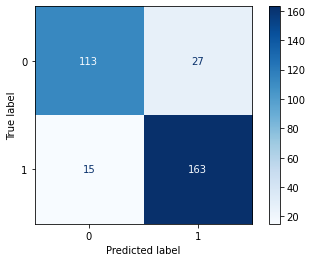

In [147]:
plot_confusion_matrix(gs_nb_tvec_model, clean_test_reddit, y_test, cmap='Blues', values_format='d');

In [148]:
tn, fp, fn, tp = confusion_matrix(y_test, y_preds).ravel()

In [149]:
spec = tn/(tn + fp)

print(f'Specificity: {round(spec,4)}')

Specificity: 0.8071


In [150]:
sens = tp/(tp+fn)

print(f'Sensitivity: {round(sens,4)}')

Sensitivity: 0.9157


The confusion matrix shows: 
- True Negatives (113) - posts that are correctly predicted as LoL
- False Positives (27) - posts that are predicted as Dota2 but are actually LoL
- False Negatives (15) - posts that are predicted as LoL but are actually Dota2
- True Positives (163) - posts that are correctly predicted as Dota2

The sensitivity of the model is 92% which is much better than the specificity (81%). The sensitivity is how often it predicts Dota 2 when its actually Dota 2 while specificity is how often it predicts LoL when its actually LoL. The model is better at predicting true Dota 2 posts than true LoL posts.  

## <a name="conclusion_recommendations"></a>Conclusion and recommendations

Stakeholders should use the Naive Bayes (TF-IDF) model as it has the highest accuracy in classifying the posts correctly. The features from the model is also easy to interpret. We also beat the baseline score of 56% with an accuracy score of 87%. To further improve the Naive Bayes model, we can try to collect more data, spend more time tuning the hyperparameters and remove frequently occuring words that are not differentiable between the 2 subreddits. One thing to note is the Naive Bayes model assumes that all the features are independent of each other. However this is rarely the case in real life as the order of words/phrases can have different meanings. This model will also not be able to differentiate other subreddit topics other than Dota 2 and LoL.

Dota 2 would be the better choice to focus their marketing on as they will be able to target areas with large audience exposure such as Competitions, professional players and teams. Instead of LoL where the target areas is within the game itself. The model is also better at predicting true Dota 2 posts than true LoL posts.

Some competitions to sponsor would be The International 10 (TI) which is next upcoming competition with a prize pool over 40 million USD. With a prize pool this large, viewership will most likely be very high.

Players and teams to sponsor would be Evil Geniuses and players from it such as iceciceice, Abed and Arteezy. Razor being a Singapore grown company will definitely resonate with iceiceice being a Singaporean professional Dota 2 player. 